In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import os
from pathlib import Path
os.environ["POLARS_MAX_THREADS"] = "80"
import polars as pl
import polars.selectors as cs

ModuleNotFoundError: No module named 'seaborn._core.plot'; 'seaborn._core' is not a package

In [7]:
import seaborn.objects as so
import seaborn as sns
import matplotlib.pyplot as plt

# Load an example dataset
penguins = sns.load_dataset("penguins")

# Create a plot using seaborn.objects
p = so.Plot(penguins, x="bill_length_mm", y="bill_depth_mm")
p = p.add(so.Dots())

# Display the plot
p.show()


ModuleNotFoundError: No module named 'seaborn._core.plot'; 'seaborn._core' is not a package

In [6]:
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42

In [ ]:
colors = [
    '#00BFFF', 
    '#FFD700', 
    '#FFC0CB', 
    '#6A5ACD', 
    '#b9fbc0', 
    '#64dfdf', 
    '#FFA500', 
    '#ff6b6b',
    '#6bd425', 
    '#FF0000', 
    '#A0B4FF'
]

In [2]:
def print_df(df: pl.DataFrame, n_rows: int = 100, str_length: int = 200, **kwargs):
    with pl.Config(fmt_str_lengths=str_length, set_tbl_rows=n_rows, **kwargs):
        display(df)

NameError: name 'pl' is not defined

In [3]:
metabolism_map = {
    'Energy metabolism': "Energy",
    'Metabolism of terpenoids and polyketides': "Terpenoids/polyketides",
    'Glycan biosynthesis and metabolism': "Glycan",
    'Metabolism of cofactors and vitamins': "Cofactors/vitamins",
    'Carbohydrate metabolism': "Carbohydrate",
    'Folding, sorting and degradation': "Folding/degradation",
    'Nucleotide metabolism': "Nucleotide",
    'Amino acid metabolism': "Amino acid",
    'Biosynthesis of other secondary metabolites': "Secondary metabolites",
    'Metabolism of other amino acids': "Other amino acids",
    'Lipid metabolism': "Lipid",
    "Xenobiotics biodegradation and metabolism": "Benzoate degradation",
}

kegg_metadata = (
    pl.read_csv(
        "/storage2/databases/VIBRANT/files/VIBRANT_KEGG_pathways_summary.tsv",
        separator="\t",
        new_columns=["map", "metabolism", "pathway", "KO"]
    )
    # .filter(pl.col("metabolism") != "Xenobiotics biodegradation and metabolism")
    .with_columns(
        pl.col("KO").str.split("~"),
        metabolism_label = pl.col("metabolism").replace(metabolism_map)
    )
    .explode("KO")
    .filter(pl.col("KO") != "")
)

NameError: name 'pl' is not defined

In [4]:
amg_metadata = (
    pl.read_csv("AMGs_metadata.tsv", separator="\t")
    .sort("protein")
    .with_columns(
        pl.col("environment").fill_null("Unknown"),
        ptn_id = pl.col("protein").rle_id(),
    )
    .with_columns(
        is_marine = pl.col("environment").str.contains("(?i)marine|salinity"),
        is_freshwater = pl.col("environment").str.contains("(?i)fresh ?water"),
        is_soil = pl.col("environment").str.contains("(?i)soil"),
        is_in_need_of_validation = pl.col("environment") == "check NCBI isolation source",
        is_host = pl.col("environment").str.contains("(?i)host|gut|digest|oral|nasal|skin|lung|respiratory|throat"),
        is_unknown = pl.col("environment") == "Unknown",
        is_engineered = pl.col("environment").str.contains("(?i)anthropogenic|built|waste ?water|sewage"),
    )
    .with_columns(
        is_other_aquatic = pl.col("environment").str.contains("(?i)water|aquatic") & ~pl.col("is_marine") & ~pl.col("is_freshwater"),
        is_other_terrestrial = pl.col("environment").str.contains("(?i)terrestrial") & ~pl.col("is_soil"),
    )
    .with_columns(
        environment_label = (
            pl.when(pl.col("is_marine")).then(pl.lit("Marine"))
            .when(pl.col("is_freshwater")).then(pl.lit("Freshwater"))
            .when(pl.col("is_soil")).then(pl.lit("Soil"))
            .when(pl.col("is_host")).then(pl.lit("Host-associated"))
            .when(pl.col("is_engineered")).then(pl.lit("Engineered"))
            .when(pl.col("is_in_need_of_validation")).then(pl.lit("Other"))
            .when(pl.col("is_unknown")).then(pl.lit("Unknown"))
            .when(pl.col("is_other_aquatic")).then(pl.lit("Other aquatic"))
            .when(pl.col("is_other_terrestrial")).then(pl.lit("Other terrestrial"))
            .otherwise(pl.lit("Other"))
        )
    )
    .drop(cs.starts_with("is_"))
    .join(kegg_metadata, on="KO", how="left")
    .filter(
        (pl.col("metabolism") != "Nucleotide metabolism") & 
        (~pl.col("KO").is_in({"K02433", "K02434", "K02435", "K01886"}))
    )
    .with_columns(
        metabolism_label = (
            pl.when(pl.col("KO") == "K00528")
            .then(pl.lit("Energy"))
            .otherwise(pl.col("metabolism_label"))
        )
    )
)
amg_metadata

NameError: name 'pl' is not defined

In [8]:
env_order = [
    "Host-associated",
    "Marine",
    "Freshwater",
    "Other aquatic",
    "Soil",
    "Other terrestrial",
    "Engineered",
    "Other",
    "Unknown",
]

met_order = [
    "Cofactors/vitamins",
    "Carbohydrate",
    "Amino acid",
    "Energy",
    "Secondary metabolites",
    "Lipid",
    "Glycan",
    "Other amino acids",
    "Folding/degradation",
    "Terpenoids/polyketides",
    "Benzoate degradation",
]

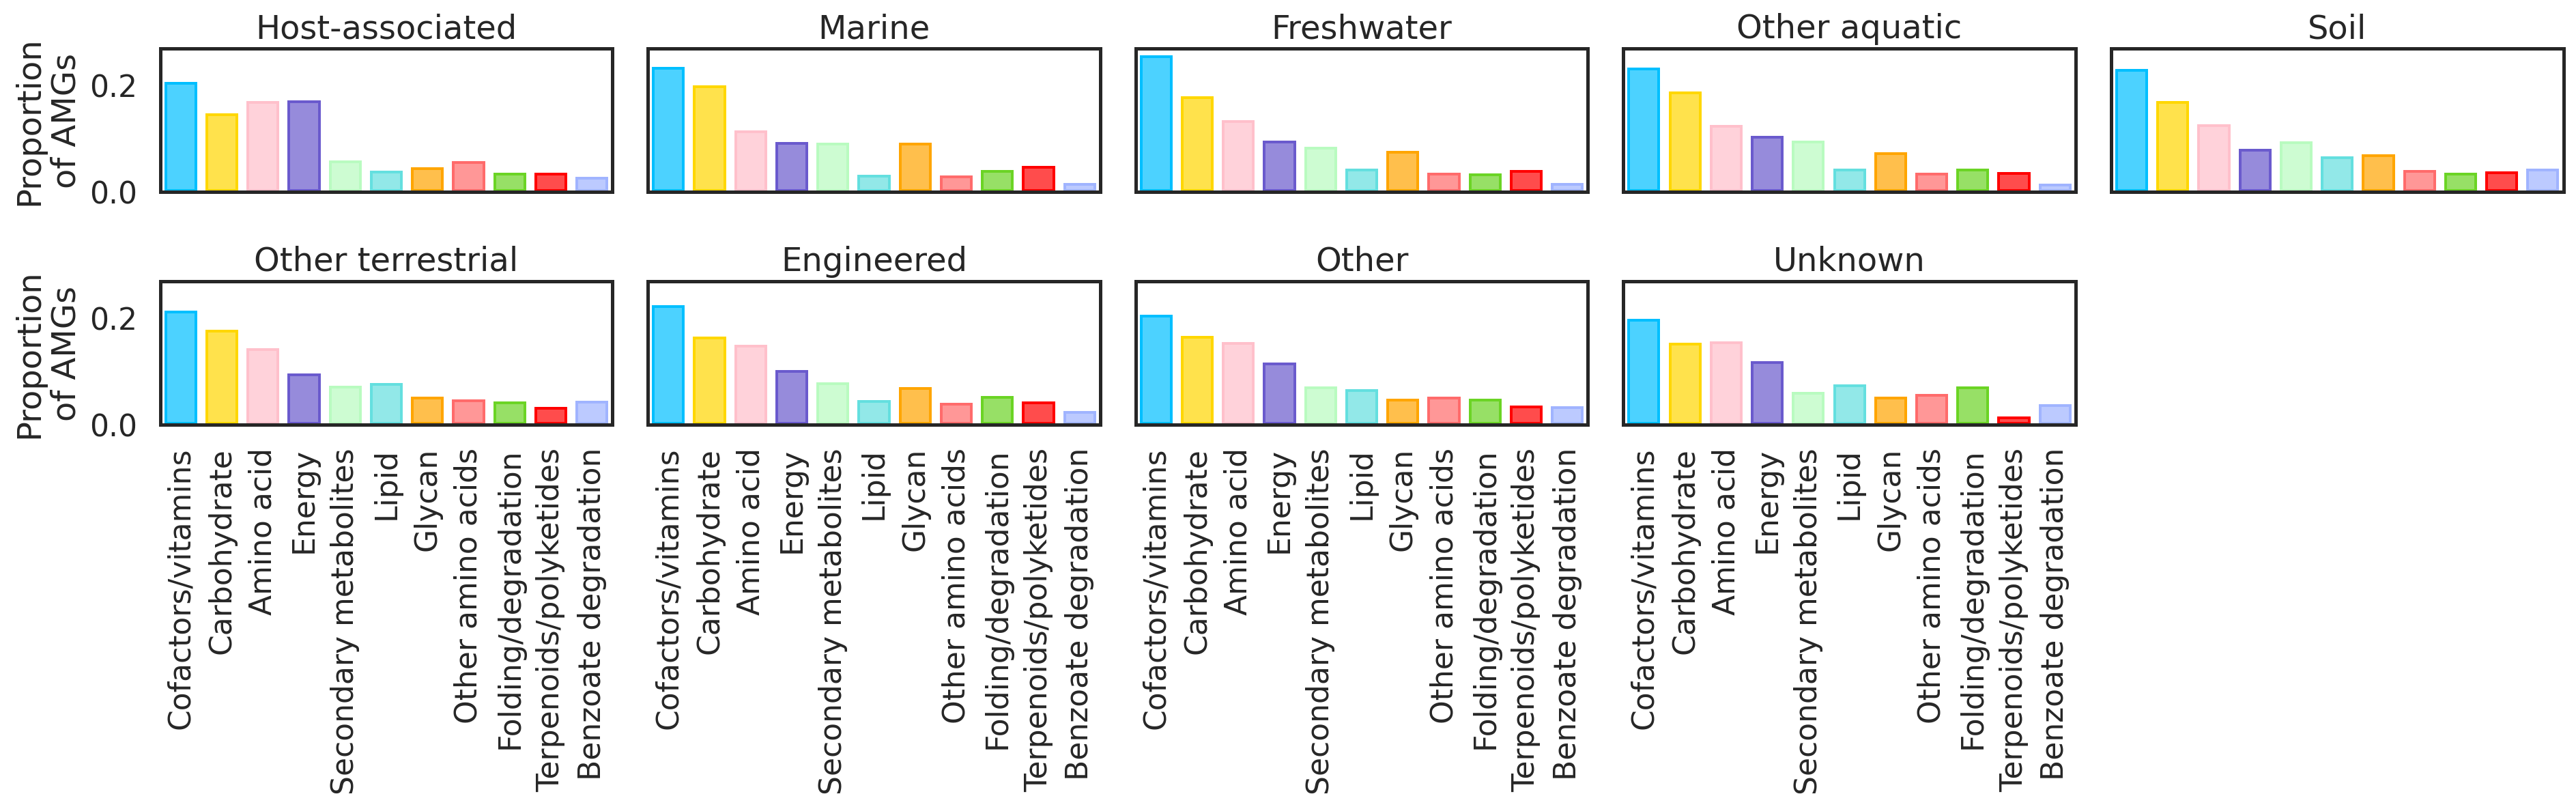

In [42]:
env_data = (
    amg_metadata
    .select("protein", "environment_label", "metabolism_label")
    .unique()
    .group_by("environment_label", "metabolism_label")
    .agg(
        count = pl.len(),
    )
    .with_columns(
        prop = pl.col("count") / pl.col("count").sum().over("environment_label"),
    )
    .sort("prop", descending=True)
)

p = (
    so.Plot(
        data=env_data,
        x="metabolism_label",
        y="prop",
        color="metabolism_label",
    )
    .facet(col="environment_label", wrap=5, order=env_order)
    .add(so.Bar(), legend=False)
    .theme(sns.axes_style("white") | sns.plotting_context("talk"))
    .layout(size=(20,6.5))
    .label(x="", y="Proportion\nof AMGs")
    .scale(color=so.Nominal(values=colors, order=met_order), x=so.Nominal(order=met_order))
    .plot()
)

for ax in p._figure.axes:
    ax.tick_params(axis="x", rotation=90)

p

In [43]:
for ext in ["pdf", "png", "svg"]:
    p.save(f"AMG_environment_associations.{ext}", bbox_inches="tight", dpi=300)

In [22]:
phyla_labels = (
    amg_metadata
    .with_columns(
        phylum = (
            pl.when(pl.col("phylum").is_null())
            .then(pl.concat_str(pl.lit("Unknown"), pl.col("host_domain"), separator=" "))
            .otherwise(pl.col("phylum"))
        )
    )
    # .with_columns(
    #     pl.col("phylum").str.split("_").list.get(0)
    # )
    # .with_columns(
    #     phylum = (
    #         pl.when(pl.col("phylum") == "Firmicutes").then(pl.lit("Bacillota"))
    #         .when(pl.col("phylum") == "Cyanobacteriota").then(pl.lit("Cyanobacteria"))
    #         .when(pl.col("phylum") == "Proteobacteria").then(pl.lit("Pseudomonadota"))
    #         .otherwise(pl.col("phylum"))
    #     ),
    # )
    ["phylum"]
    .value_counts()
    .with_columns(
        above = pl.col("count") >= 250,
    )
    .with_columns(
        phyla_label = (
            pl.when(pl.col("above"))
            .then(pl.col("phylum"))
            .otherwise(pl.lit("Other"))
        )
    )
    .drop("above", "count")
)

host_taxon_data = (
    amg_metadata
    .join(phyla_labels, on="phylum")
    .with_columns(
        phyla_label = (
            pl.when(pl.col("phyla_label") == "Other")
            .then(pl.concat_str(pl.lit("Other"), pl.col("host_domain"), separator=" "))
            .otherwise(pl.col("phyla_label"))
        )
    )
    .select("protein", "phyla_label", "metabolism_label", "host_domain")
    .unique()
    .group_by("phyla_label", "metabolism_label")
    .agg(
        pl.first("host_domain"),
        count = pl.len(),
    )
    .with_columns(
        prop = pl.col("count") / pl.col("count").sum().over("phyla_label"),
    )
    .sort(["host_domain", "phyla_label", "prop"], descending=[False, False, True])
)

# host_taxon_data
host_taxon_data.select("phyla_label", "host_domain").unique()

phyla_label,host_domain
str,str
"""Cyanobacteriot…","""Bacteria"""
"""Bacillota""","""Bacteria"""
"""Bacillota_A""","""Bacteria"""
"""Thermoproteota…","""Archaea"""
"""Bacteroidota""","""Bacteria"""
"""Myxococcota""","""Bacteria"""
"""Other Archaea""","""Archaea"""
"""Planctomycetot…","""Bacteria"""
"""Bacillota_C""","""Bacteria"""


In [31]:
host_order = [
    'Nanoarchaeota',
    'Other Archaea',
    'Thermoproteota',

    'Acidobacteriota',
    'Actinobacteriota',
    'Actinomycetota',
    'Bacillota',
    'Bacillota_A',
    'Bacillota_C',
    'Bacteroidota',
    'Chloroflexota',
    'Cyanobacteriota',
    'Desulfobacterota',
    'Myxococcota',
    'Patescibacteria',
    'Planctomycetota',
    'Pseudomonadota',
    'Spirochaetota',
    'Verrucomicrobiota',
    'Other Bacteria',
]

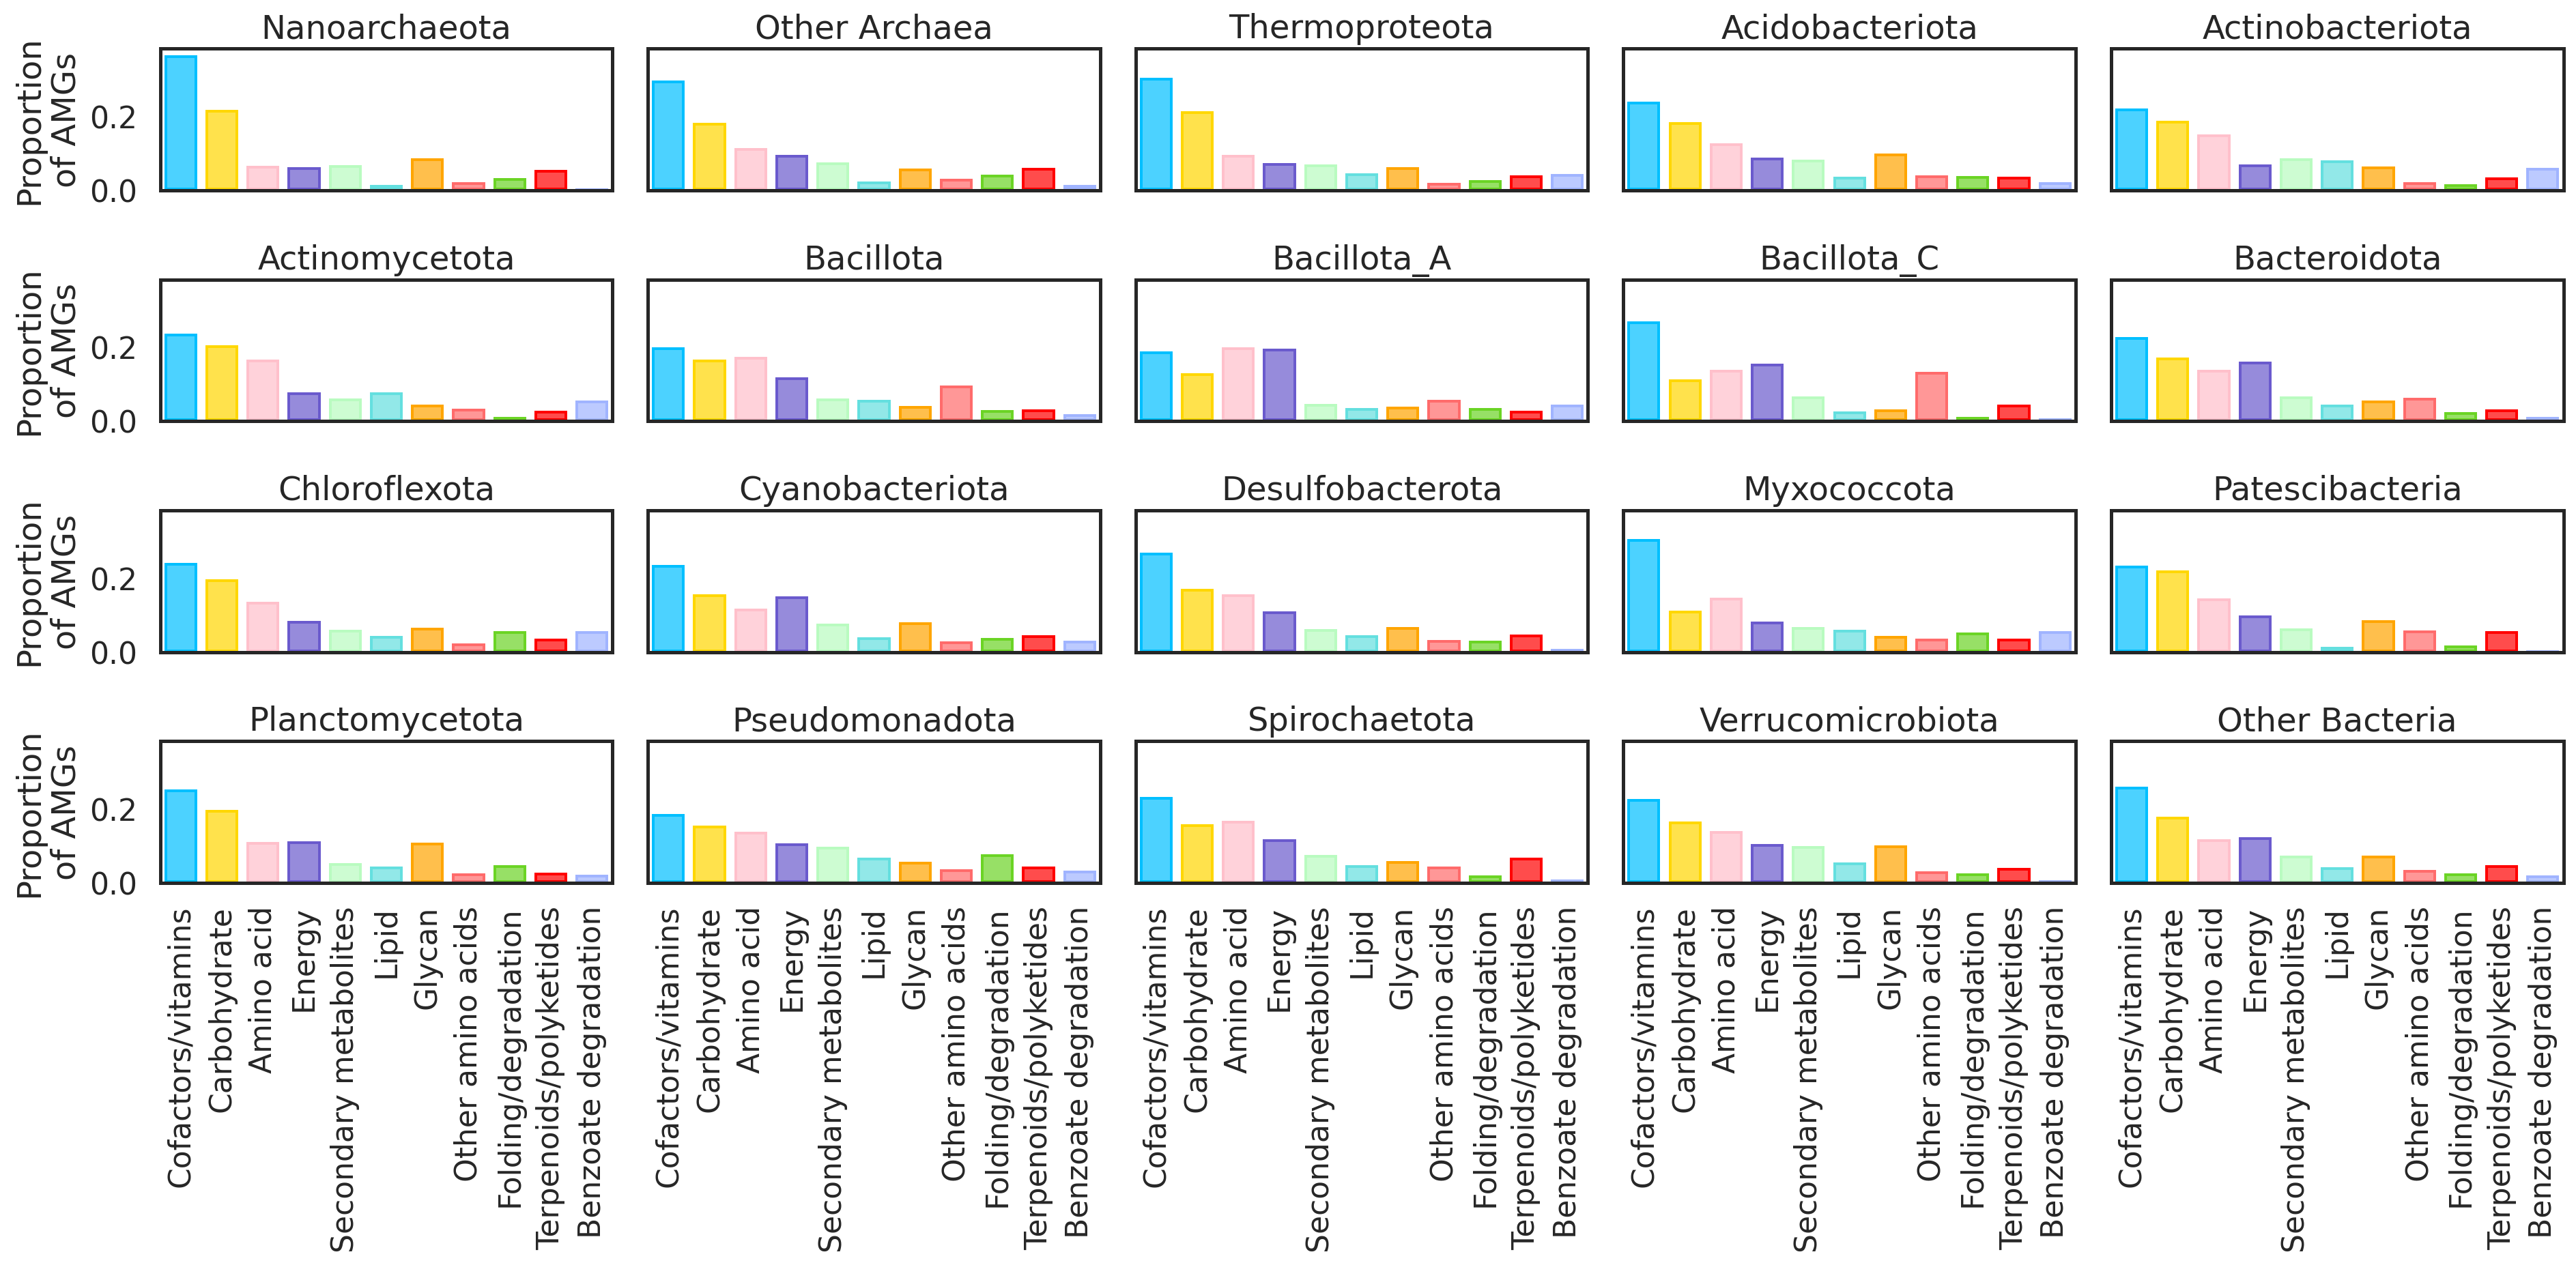

In [44]:
p = (
    so.Plot(
        data=host_taxon_data,
        x="metabolism_label",
        y="prop",
        color="metabolism_label",
    )
    .facet(col="phyla_label", wrap=5, order=host_order)
    .add(so.Bar(), legend=False)
    .theme(sns.axes_style("white") | sns.plotting_context("talk"))
    .layout(size=(20,10))
    .label(x="", y="Proportion\nof AMGs")
    .scale(color=so.Nominal(values=colors, order=met_order), x=so.Nominal(order=met_order))
    .plot()
)

for ax in p._figure.axes:
    ax.tick_params(axis="x", rotation=90)

p

In [45]:
for ext in ["pdf", "png", "svg"]:
    p.save(f"AMG_host_phyla_associations.{ext}", bbox_inches="tight", dpi=300)